# Basic RSI strategy

## Single backtest

In [1]:
import vectorbtpro as vbt
import numpy as np
import pandas as pd

In [2]:
data = vbt.BinanceData.fetch('BTCUSDT')
data

0it [00:00, ?it/s]

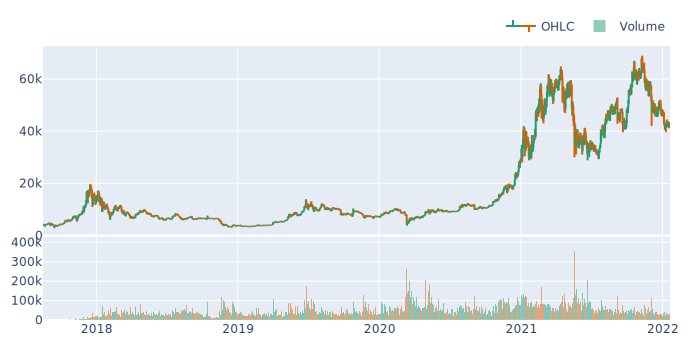

In [11]:
data.data['BTCUSDT'].vbt.ohlcv.plot().show_svg()

In [12]:
data.data['BTCUSDT'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1618 entries, 2017-08-17 00:00:00+00:00 to 2022-01-20 00:00:00+00:00
Freq: D
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Open                1618 non-null   float64            
 1   High                1618 non-null   float64            
 2   Low                 1618 non-null   float64            
 3   Close               1618 non-null   float64            
 4   Volume              1618 non-null   float64            
 5   Close time          1618 non-null   datetime64[ns, UTC]
 6   Quote volume        1618 non-null   float64            
 7   Number of trades    1618 non-null   int64              
 8   Taker base volume   1618 non-null   float64            
 9   Taker quote volume  1618 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(8), int64(1)
memory usage: 139.0 KB


In [13]:
open_price = data.get('Open')
close_price = data.get('Close')

In [14]:
vbt.RSI

vectorbtpro.indicators.custom.RSI

In [15]:
vbt.talib('RSI')

vectorbtpro.indicators.factory.talib.RSI

In [16]:
vbt.ta('RSIIndicator')

vectorbtpro.indicators.factory.ta.RSIIndicator

In [17]:
vbt.pandas_ta('RSI')

vectorbtpro.indicators.factory.pandas_ta.RSI

In [18]:
help(vbt.RSI.run)

Help on method run:

run(close, window=Default(value=14), ewm=Default(value=False), short_name='rsi', hide_params=None, hide_default=True, **kwargs) method of vectorbtpro.generic.analyzable.MetaAnalyzable instance
    Run `RSI` indicator.
    
    * Inputs: `close`
    * Parameters: `window`, `ewm`
    * Outputs: `rsi`
    
    Pass a list of parameter names as `hide_params` to hide their column levels.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `vectorbtpro.indicators.factory.run_pipeline`.



In [19]:
rsi = vbt.RSI.run(open_price)
rsi

In [20]:
rsi.rsi

Open time
2017-08-17 00:00:00+00:00          NaN
2017-08-18 00:00:00+00:00          NaN
2017-08-19 00:00:00+00:00          NaN
2017-08-20 00:00:00+00:00          NaN
2017-08-21 00:00:00+00:00          NaN
                               ...    
2022-01-16 00:00:00+00:00    27.800150
2022-01-17 00:00:00+00:00    28.975756
2022-01-18 00:00:00+00:00    28.889430
2022-01-19 00:00:00+00:00    31.855444
2022-01-20 00:00:00+00:00    38.664532
Freq: D, Name: Open, Length: 1618, dtype: float64

In [21]:
entries = rsi.rsi.vbt.crossed_below(30)
entries

Open time
2017-08-17 00:00:00+00:00    False
2017-08-18 00:00:00+00:00    False
2017-08-19 00:00:00+00:00    False
2017-08-20 00:00:00+00:00    False
2017-08-21 00:00:00+00:00    False
                             ...  
2022-01-16 00:00:00+00:00     True
2022-01-17 00:00:00+00:00    False
2022-01-18 00:00:00+00:00    False
2022-01-19 00:00:00+00:00    False
2022-01-20 00:00:00+00:00    False
Freq: D, Name: Open, Length: 1618, dtype: bool

In [22]:
exits = rsi.rsi.vbt.crossed_above(70)
exits

Open time
2017-08-17 00:00:00+00:00    False
2017-08-18 00:00:00+00:00    False
2017-08-19 00:00:00+00:00    False
2017-08-20 00:00:00+00:00    False
2017-08-21 00:00:00+00:00    False
                             ...  
2022-01-16 00:00:00+00:00    False
2022-01-17 00:00:00+00:00    False
2022-01-18 00:00:00+00:00    False
2022-01-19 00:00:00+00:00    False
2022-01-20 00:00:00+00:00    False
Freq: D, Name: Open, Length: 1618, dtype: bool

In [23]:
entries = rsi.rsi_crossed_below(30)
exits = rsi.rsi_crossed_above(70)

In [24]:
def plot_rsi(rsi, entries, exits):
    fig = rsi.plot()
    entries.vbt.signals.plot_as_entry_markers(rsi.rsi, fig=fig)
    exits.vbt.signals.plot_as_exit_markers(rsi.rsi, fig=fig)
    return fig

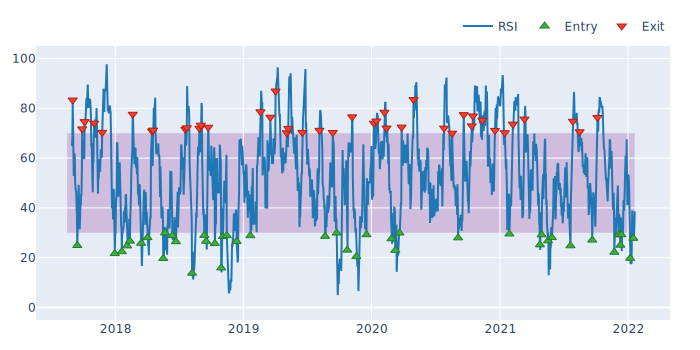

In [25]:
plot_rsi(rsi, entries, exits).show_svg()

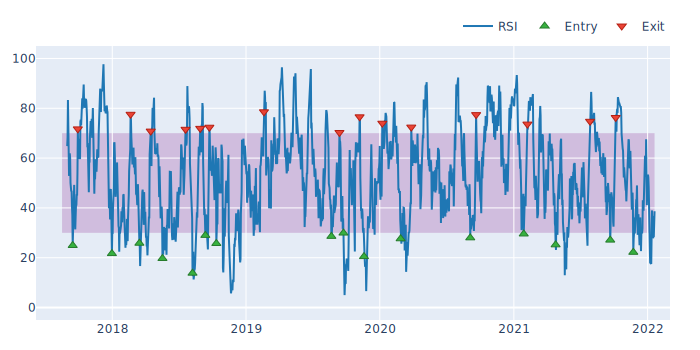

In [26]:
clean_entries, clean_exits = entries.vbt.signals.clean(exits)

plot_rsi(rsi, clean_entries, clean_exits).show_svg()

In [27]:
clean_entries.vbt.signals.total()

16

In [28]:
clean_exits.vbt.signals.total()

15

In [29]:
ranges = clean_entries.vbt.signals.between_ranges(other=clean_exits)
ranges.duration.mean(wrap_kwargs=dict(to_timedelta=True))

Timedelta('40 days 01:36:00')

In [30]:
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=clean_entries, 
    exits=clean_exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
pf

In [31]:
pf.stats()

Start                         2017-08-17 00:00:00+00:00
End                           2022-01-20 00:00:00+00:00
Period                               1618 days 00:00:00
Start Value                                  157.043476
End Value                                    110.863162
Total Return [%]                              -29.40607
Benchmark Return [%]                         876.134868
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               58.04434
Max Drawdown Duration                1475 days 00:00:00
Total Trades                                         16
Total Closed Trades                                  15
Total Open Trades                                     1
Open Trade PnL                               -27.307548
Win Rate [%]                                  53.333333
Best Trade [%]                                35.794383
Worst Trade [%]                              -37

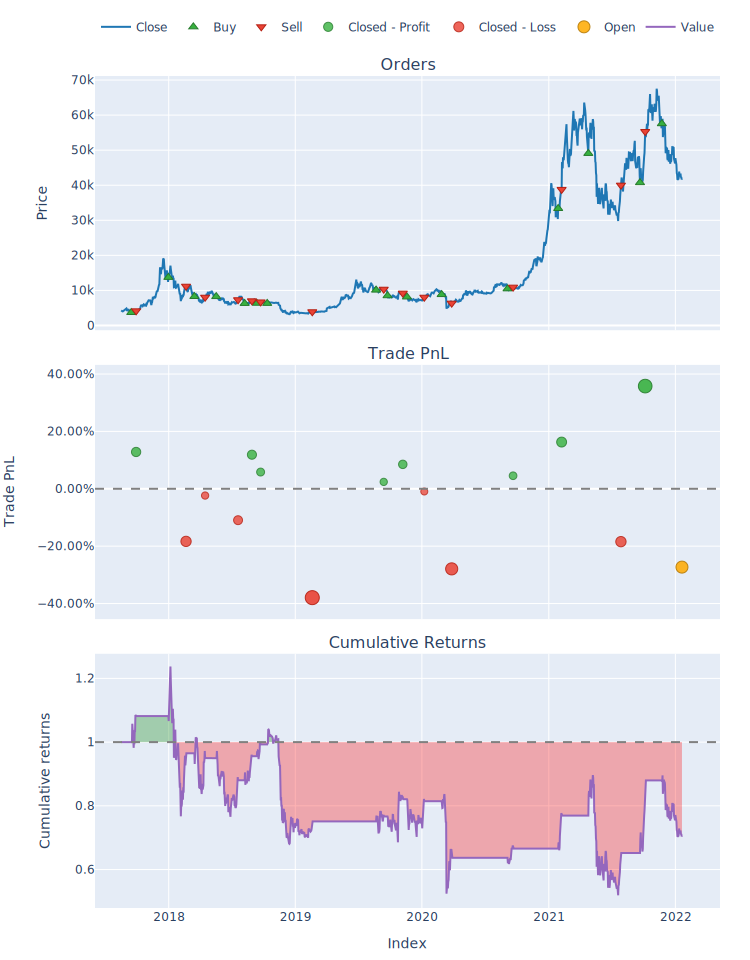

In [32]:
pf.plot(settings=dict(bm_returns=False)).show_svg()

## Multiple backtests

### Using for-loop

In [33]:
def test_rsi(window=14, ewm=False, lower_th=30, upper_th=70):
    rsi = vbt.RSI.run(open_price, window=window, ewm=ewm)
    entries = rsi.rsi_crossed_below(lower_th)
    exits = rsi.rsi_crossed_above(upper_th)
    pf = vbt.Portfolio.from_signals(
        close=close_price, 
        entries=entries, 
        exits=exits,
        size=100,
        size_type='value',
        init_cash='auto')
    return pf.stats([
        'total_return', 
        'total_trades', 
        'win_rate', 
        'expectancy'
    ])

In [34]:
test_rsi()

Total Return [%]    -29.40607
Total Trades               16
Win Rate [%]        53.333333
Expectancy          -1.258184
dtype: object

In [35]:
test_rsi(lower_th=20, upper_th=80)

Total Return [%]    59.548087
Total Trades                8
Win Rate [%]        71.428571
Expectancy           9.492297
dtype: object

In [36]:
from itertools import product

lower_ths = range(20, 31)
upper_ths = range(70, 81)
th_combs = list(product(lower_ths, upper_ths))
len(th_combs)

121

In [37]:
comb_stats = [
    test_rsi(lower_th=lower_th, upper_th=upper_th)
    for lower_th, upper_th in th_combs
]

In [38]:
comb_stats_df = pd.DataFrame(comb_stats)
comb_stats_df

,Total Return [%],Total Trades,Win Rate [%],Expectancy
0,-7.610326,9,50.000000,-1.399830
1,-5.846478,9,62.500000,-1.074616
2,14.523067,9,75.000000,1.955225
3,48.083175,9,62.500000,6.774067
4,58.143523,9,62.500000,8.141884
...,...,...,...,...
116,30.083651,14,53.846154,4.688153
117,14.769901,13,50.000000,3.717156
118,9.435476,12,45.454545,3.698104
119,19.680743,12,54.545455,4.790308


In [39]:
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs, 
    names=['lower_th', 'upper_th'])
comb_stats_df

Total Return [%]  Total Trades  Win Rate [%]  Expectancy
lower_th upper_th                                                          
20       70               -7.610326             9     50.000000   -1.399830
         71               -5.846478             9     62.500000   -1.074616
         72               14.523067             9     75.000000    1.955225
         73               48.083175             9     62.500000    6.774067
         74               58.143523             9     62.500000    8.141884
...                             ...           ...           ...         ...
30       76               30.083651            14     53.846154    4.688153
         77               14.769901            13     50.000000    3.717156
         78                9.435476            12     45.454545    3.698104
         79               19.680743            12     54.545455    4.790308
         80               22.227118            12     54.545455    5.088901

[121 rows x 4 columns]

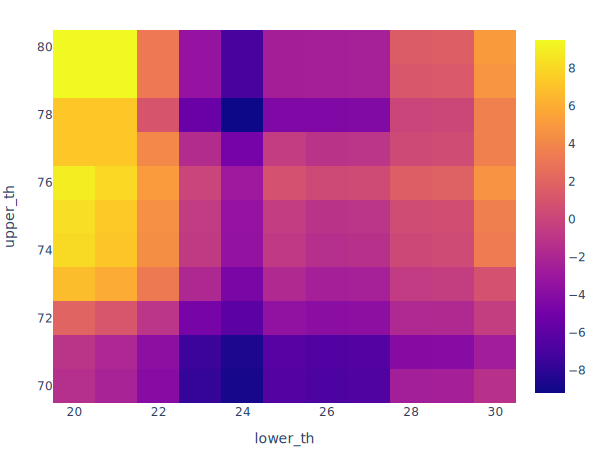

In [40]:
comb_stats_df['Expectancy'].vbt.heatmap().show_svg()

### Using columns

In [43]:
windows = list(range(8, 21))
ewms = [False, True]
lower_ths = list(range(20, 31))
upper_ths = list(range(70, 81))

In [44]:
rsi = vbt.RSI.run(
    open_price, 
    window=windows, 
    ewm=ewms, 
    param_product=True)
rsi.rsi.columns

MultiIndex([( 8, False),
            ( 8,  True),
            ( 9, False),
            ( 9,  True),
            (10, False),
            (10,  True),
            (11, False),
            (11,  True),
            (12, False),
            (12,  True),
            (13, False),
            (13,  True),
            (14, False),
            (14,  True),
            (15, False),
            (15,  True),
            (16, False),
            (16,  True),
            (17, False),
            (17,  True),
            (18, False),
            (18,  True),
            (19, False),
            (19,  True),
            (20, False),
            (20,  True)],
           names=['rsi_window', 'rsi_ewm'])

In [45]:
lower_ths_prod, upper_ths_prod = zip(*product(lower_ths, upper_ths))
len(lower_ths_prod)

121

In [46]:
len(upper_ths_prod)

121

In [47]:
lower_th_index = pd.Index(lower_ths_prod, name='lower_th')
entries = rsi.rsi_crossed_below(lower_th_index)
entries.columns

MultiIndex([(20,  8, False),
            (20,  8,  True),
            (20,  9, False),
            (20,  9,  True),
            (20, 10, False),
            (20, 10,  True),
            (20, 11, False),
            (20, 11,  True),
            (20, 12, False),
            (20, 12,  True),
            ...
            (30, 16, False),
            (30, 16,  True),
            (30, 17, False),
            (30, 17,  True),
            (30, 18, False),
            (30, 18,  True),
            (30, 19, False),
            (30, 19,  True),
            (30, 20, False),
            (30, 20,  True)],
           names=['lower_th', 'rsi_window', 'rsi_ewm'], length=3146)

In [48]:
upper_th_index = pd.Index(upper_ths_prod, name='upper_th')
exits = rsi.rsi_crossed_above(upper_th_index)
exits.columns

MultiIndex([(70,  8, False),
            (70,  8,  True),
            (70,  9, False),
            (70,  9,  True),
            (70, 10, False),
            (70, 10,  True),
            (70, 11, False),
            (70, 11,  True),
            (70, 12, False),
            (70, 12,  True),
            ...
            (80, 16, False),
            (80, 16,  True),
            (80, 17, False),
            (80, 17,  True),
            (80, 18, False),
            (80, 18,  True),
            (80, 19, False),
            (80, 19,  True),
            (80, 20, False),
            (80, 20,  True)],
           names=['upper_th', 'rsi_window', 'rsi_ewm'], length=3146)

In [49]:
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=entries, 
    exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
pf

In [50]:
stats_df = pf.stats([
    'total_return', 
    'total_trades', 
    'win_rate', 
    'expectancy'
], agg_func=None)
stats_df

Total Return [%]  Total Trades  \
lower_th upper_th rsi_window rsi_ewm                                   
20       70       8          False          -19.387201            27   
                             True             1.479363            26   
                  9          False          -44.831196            22   
                             True            -1.901612            22   
                  10         False          -47.952486            16   
...                                                ...           ...   
30       80       18         True            29.695487             8   
                  19         False           -0.856795             5   
                             True            51.239924             8   
                  20         False          -37.343350             4   
                             True            33.534784             8   

                                      Win Rate [%]  Expectancy  
lower_th upper_th rsi_window rsi_ewm                            
20       70       8          False       53.846154   -0.512684  
                             True        64.000000    0.182982  
                  9          False       52.380952   -3.810420  
                             True        66.666667    0.043674  
                  10         False       60.000000   -5.769271  
...                                            ...         ...  
30       80       18         True        57.142857    6.865879  
                  19         False       75.000000    6.385719  
                             True        57.142857    9.508749  
                  20         False       33.333333  -16.159733  
                             True        57.142857    7.032204  

[3146 rows x 4 columns]

In [51]:
stats_df['Expectancy'].groupby('rsi_window').mean()

rsi_window
8     0.559154
9    -0.874399
10   -2.544668
11   -2.014821
12   -2.104681
13    1.824517
14    0.933219
15    3.287030
16    3.350205
17    6.763109
18    4.374821
19    3.515993
20    4.419658
Name: Expectancy, dtype: float64

In [52]:
stats_df.sort_values(by='Expectancy', ascending=False).head()

Total Return [%]  Total Trades  \
lower_th upper_th rsi_window rsi_ewm                                   
24       74       20         True           136.770984             7   
23       74       20         True           136.770984             7   
24       77       17         False          115.743439             7   
         78       17         False          115.068589             7   
23       75       19         True           133.213236             7   

                                      Win Rate [%]  Expectancy  
lower_th upper_th rsi_window rsi_ewm                            
24       74       20         True        71.428571   19.538712  
23       74       20         True        71.428571   19.538712  
24       77       17         False       83.333333   19.288314  
         78       17         False       83.333333   19.175839  
23       75       19         True        71.428571   19.030462

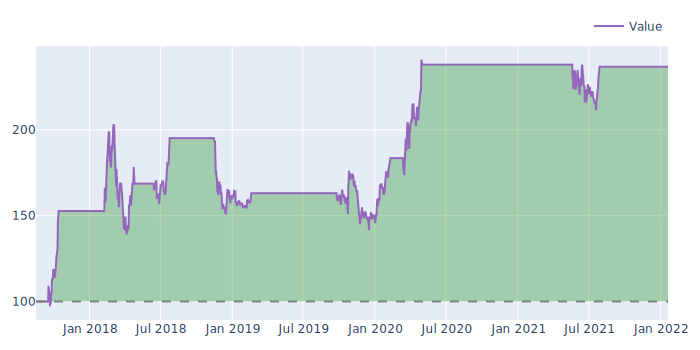

In [53]:
pf[(24, 74, 20, True)].plot_value().show_svg()

In [54]:
data = vbt.BinanceData.fetch(['BTCUSDT', 'ETHUSDT'])

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [57]:
open_price = data.get('Open')
close_price = data.get('Close')

In [58]:
rsi = vbt.RSI.run(
    open_price, 
    window=windows, 
    ewm=ewms, 
    param_product=True)
entries = rsi.rsi_crossed_below(lower_th_index)
exits = rsi.rsi_crossed_above(upper_th_index)
pf = vbt.Portfolio.from_signals(
    close=close_price, 
    entries=entries, 
    exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)
stats_df = pf.stats([
    'total_return', 
    'total_trades', 
    'win_rate', 
    'expectancy'
], agg_func=None)

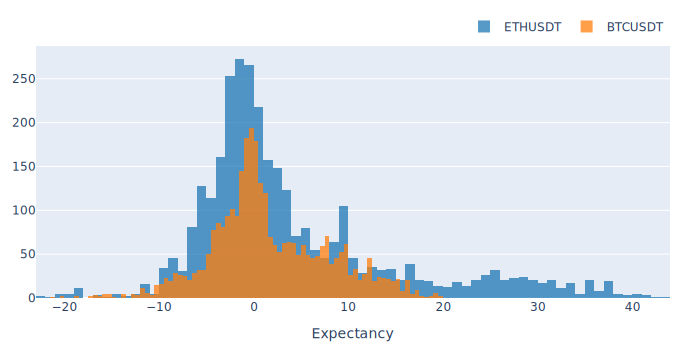

In [59]:
eth_mask = stats_df.index.get_level_values('symbol') == 'ETHUSDT'
btc_mask = stats_df.index.get_level_values('symbol') == 'BTCUSDT'
pd.DataFrame({
    'ETHUSDT': stats_df[eth_mask]['Expectancy'].values,
    'BTCUSDT': stats_df[btc_mask]['Expectancy'].values
}).vbt.histplot(xaxis=dict(title="Expectancy")).show_svg()